# 毕业论文`GRAD`
## 要素柱状图

---
*@author: Evan*\
*@date: 2023-11-25*

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask, average_data

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [7]:
def prepare_boxdata(var, years, month, shp_file, inputdir=None):

    if inputdir is None:
        inputdir = processed_dir
    else:
        inputdir = inputdir
    
    files = [os.path.join(inputdir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in years]
    years_avg_data = average_data(files, var)
    time_avg_data = years_avg_data.mean(dim="time")

    # Read shapefile
    shp = gpd.read_file(shp_file)

    # Extract longitude and latitude
    lon = time_avg_data.longitude
    lat = time_avg_data.latitude

    # Create a mask based on the polygon
    mask = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y', 'x'))

    # Apply the mask to the averaged data
    masked_data = time_avg_data.where(mask_da)

    # Remove NaN values and flatten to a 1D array
    flat_data = masked_data.values[~np.isnan(masked_data.values)].flatten()

    return flat_data


In [8]:
var = 'SFC_TMP'
month = "Sep"

low_years = np.array([2016,2015,2014])
high_years = np.array([2022,2021,2019])
shp_file = shp_files['PRD_adm']

low = prepare_boxdata(var, low_years, month, shp_file, inputdir=None)
high = prepare_boxdata(var, high_years, month, shp_file, inputdir=None)

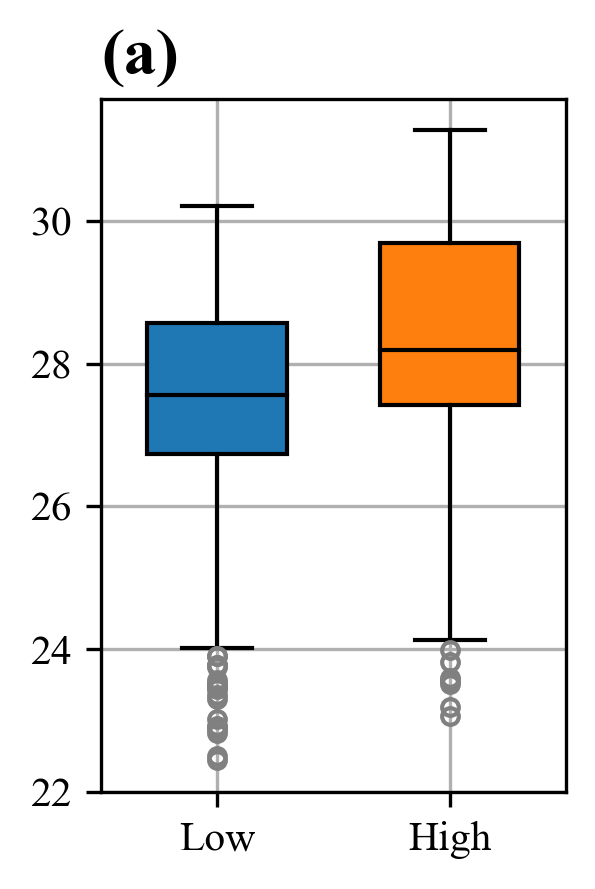

In [11]:
boxdata = [low, high]

medianprop = {'linestyle':'-','color':'black'}
flierprop = {'marker':'o','markersize':4,'markeredgecolor':'gray',}
strdict = {'fontsize': 16, 'fontweight': 'bold'}

fig = plt.figure(figsize=(2, 3),dpi=300)
ax = fig.subplots(1,1)
box = ax.boxplot(boxdata, patch_artist=True,widths=0.6,
                 medianprops=medianprop,
                 showfliers=True,flierprops=flierprop)

colors = ['tab:blue', 'tab:orange']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks([1, 2], ['Low', 'High'])

ax.set_title('(a)',loc='left',fontdict=strdict)
ax.grid(None)
plt.show()